# PainAttnNet Implementation for EEG Classification

In [45]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split  
import numpy as np   
import matplotlib.pyplot as plt
import pickle

#transformer
import torch.nn.functional as F
import copy
from copy import deepcopy


# torch.manual_seed(0)
# np.random.seed(0)


print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Numpy version: {np.__version__}")

PyTorch version: 2.5.1
Torchvision version: 0.20.1
Numpy version: 1.26.4


---
## Data Import and Formatting for Training

In [46]:

#load data from data.pkl in a tensor
with open('data.pkl', 'rb') as file: #récupération des données
    data = pickle.load(file)

#filtrage des signaux EEG
# Définir les fréquences de coupure et de la fréquence d'échantillonnage du signal
low_cutoff = 0.53
high_cutoff = 40
sample_rate = 173.61

# Conception du filtre passe-bande
nyquist = 0.5 * sample_rate
low = low_cutoff / nyquist
high = high_cutoff / nyquist
b, a = butter(4, [low, high], btype='band')

# Séparer les labels des données
labels = data[:, 0]  # La première colonne correspond aux labels
signals = data[:, 1:]  # Les colonnes restantes sont les données à filtrer

# Appliquer le filtre passe-bande aux données
filtered_signals = filtfilt(b, a, signals, axis=1)

# Faire une copie des signaux filtrés pour éviter les strides négatifs (c'est à dire pour que les données soient stockées de manière contiguë en mémoire)
filtered_signals = filtered_signals.copy()

# Créer un Dataset personnalisé
class EEGDataset(torch.utils.data.Dataset):
    def __init__(self, signals, labels):
        self.signals = torch.tensor(signals, dtype=torch.float32).unsqueeze(1)  # Ajouter une dimension pour le canal
        self.labels = torch.tensor(labels, dtype=torch.long)
        #Modification labels sain et malade
        for idx in range(len(self.labels)):
            match labels[idx]:
                case 1: #A
                    self.labels[idx]=0
                case 2: #B
                    self.labels[idx]=1
                case 3: #C
                    self.labels[idx]=2
                case 4: #D
                    self.labels[idx]=3
                case 5: #E
                    self.labels[idx]=4

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        return self.signals[idx], self.labels[idx]
    
    def __getlabel__(self, idx):
        return self.labels[idx]


# Créer le dataset personnalisé
dataset = EEGDataset(filtered_signals, labels)
#print(dataset.labels)

## Comparaison visuelle du signal filtré et original

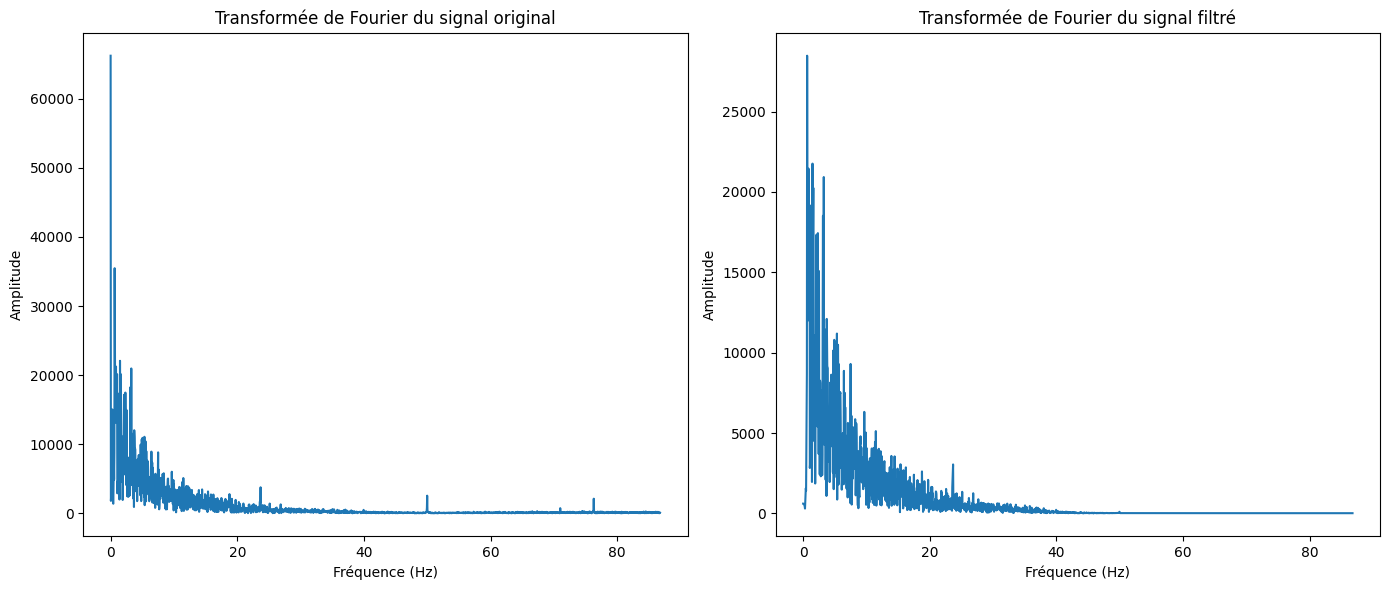

In [47]:
#Transformée de Fourier d'un des signaux filtrés et de sa version originale

# Sélectionner un signal aléatoire
random_index = np.random.randint(0, data.shape[0])
original_signal = data[random_index]
filtered_signal = filtered_signals[random_index]

# Calculer la transformée de Fourier
original_fft = np.fft.fft(original_signal)
filtered_fft = np.fft.fft(filtered_signal)

# Calculer les fréquences correspondantes
freqs = np.fft.fftfreq(len(original_signal), d=1/sample_rate)

# Ajuster les longueurs pour correspondre
half_n = len(original_signal) // 2
freqs = freqs[:half_n]
original_fft = original_fft[:half_n]
filtered_fft = filtered_fft[:half_n]

# Afficher les résultats
plt.figure(figsize=(14, 6))

# Transformée de Fourier du signal original
plt.subplot(1, 2, 1)
plt.plot(freqs, np.abs(original_fft))
plt.title('Transformée de Fourier du signal original')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude')

# Transformée de Fourier du signal filtré
plt.subplot(1, 2, 2)
plt.plot(freqs, np.abs(filtered_fft))
plt.title('Transformée de Fourier du signal filtré')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

## Diviser les données en ensembles d'entraînement, de validation et de test

In [48]:
# Calculate sizes for split
train_size = int(0.8 * 100)  # 80 samples per class with 100 the size of each set
val_size = int(0.2 * 100)    # 10 samples per class
test_size = 100 - train_size - val_size  # Remaining samples per class

# Initialize empty lists for each split
train_data_list = []
val_data_list = []
test_data_list = []

# Split each class separately and combine
for set_start in range(0, len(dataset), 100):  # Each set has 100 samples
    set_data = torch.utils.data.Subset(dataset, range(set_start, set_start + 100))
    class_splits = random_split(set_data, [train_size, val_size, test_size])
    train_data_list.append(class_splits[0])
    val_data_list.append(class_splits[1])
    test_data_list.append(class_splits[2])

# Combine the splits using ConcatDataset
train_data = torch.utils.data.ConcatDataset(train_data_list)
val_data = torch.utils.data.ConcatDataset(val_data_list)
test_data = torch.utils.data.ConcatDataset(test_data_list)

# Create DataLoaders
batch_size = 128  # Réduire la taille du batch
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print("Ensemble d'entraînement :", len(train_data))  
print("Ensemble de validation :", len(val_data))  
print("Ensemble de test :", len(test_data))

Ensemble d'entraînement : 400
Ensemble de validation : 100
Ensemble de test : 0


## Visualize a Batch of Training Data

(128, 1, 4097)


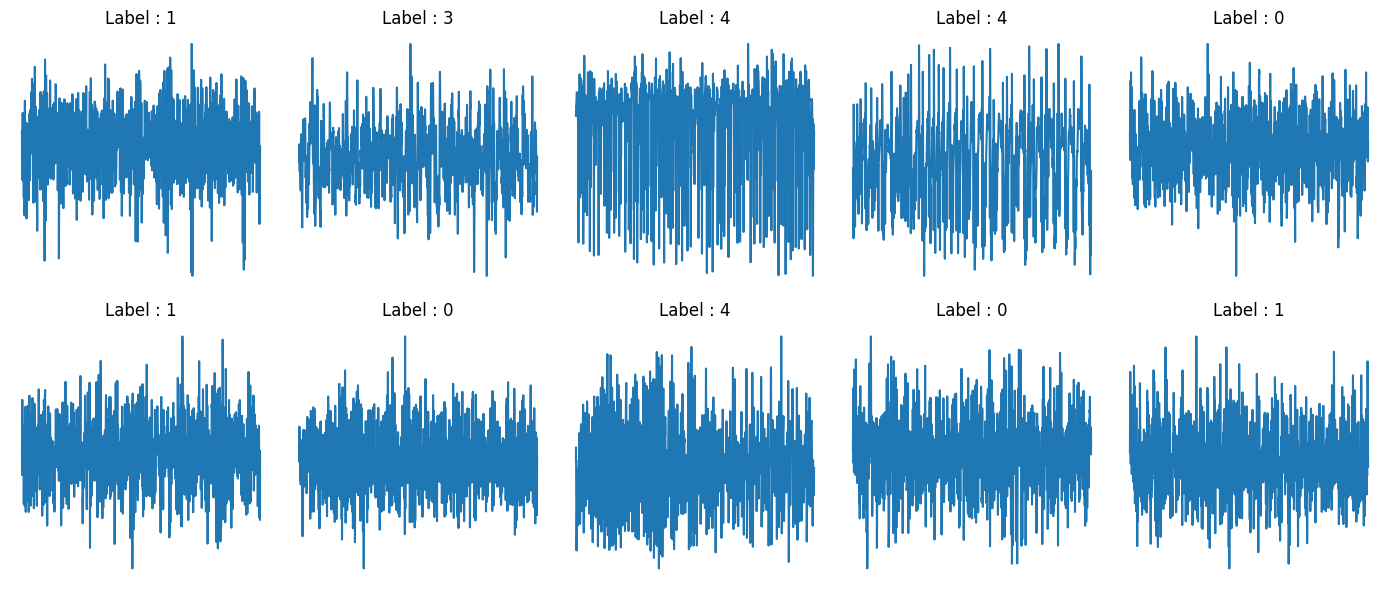

In [49]:
# Sélectionner un batch aléatoire de signaux d'entraînement
dataiter = iter(train_loader)
signals, labels = next(dataiter)
signals = signals.numpy()
print(signals.shape)

# Afficher les signaux dans le batch, avec les labels correspondants
plt.figure(figsize=(14, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.plot(signals[i].T)
    plt.title(f"Label : {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()


---
## Define the Network Architecture

### Define the Models

In [50]:
# Model MSCN (Multi-Scale Convolutional Network)
class MSCN(nn.Module):
    def __init__(self,mscn_output_channels,model_dim,kernel_size_short,kernel_size_medium,kernel_size_long,stride_short,stride_medium,stride_long):
        super().__init__()
        dropout = 0.5

        self.short_scale = nn.Sequential(
            nn.Conv1d(1, mscn_output_channels, kernel_size_short, stride_short, dilation=1, bias=False, padding=9), #anciennement kernel_size=50, stride=6, padding=24 
            nn.BatchNorm1d(mscn_output_channels), 
            nn.GELU(),
            nn.MaxPool1d(kernel_size=8, stride=2, padding=4),
            nn.Dropout(dropout),

            nn.Conv1d(mscn_output_channels, 128, kernel_size=8, stride=1, bias=False, padding=4),
            nn.BatchNorm1d(128),
            nn.GELU(),

            nn.Conv1d(128, mscn_output_channels, kernel_size=8, stride=1, bias=False, padding=4),
            nn.BatchNorm1d(mscn_output_channels),
            nn.GELU(),

            nn.MaxPool1d(kernel_size=4, stride=4, padding=2)
        )

        self.medium_scale = nn.Sequential(
            nn.Conv1d(1, mscn_output_channels, kernel_size_medium, stride_medium, dilation=1, bias=False, padding=38), #anciennement kernel_size=512, stride=42, padding=256
            nn.BatchNorm1d(mscn_output_channels),
            nn.GELU(),
            nn.MaxPool1d(kernel_size=4, stride=4, padding=0),
            nn.Dropout(dropout),

            nn.Conv1d(mscn_output_channels, 128, kernel_size=4, stride=1, bias=False, padding=3),
            nn.BatchNorm1d(128),
            nn.GELU(),

            nn.Conv1d(128, mscn_output_channels, kernel_size=4, stride=1, bias=False, padding=3),
            nn.BatchNorm1d(mscn_output_channels),
            nn.GELU(),

            nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        )

        self.long_scale = nn.Sequential(
            nn.Conv1d(1, mscn_output_channels, kernel_size_long, stride_long, dilation=1, bias=False, padding=67), #anciennement kernel_size=1024, stride=84, padding=512
            nn.BatchNorm1d(mscn_output_channels),
            nn.GELU(),
            nn.MaxPool1d(kernel_size=8, stride=8, padding=0),
            nn.Dropout(dropout),

            nn.Conv1d(mscn_output_channels, 128, kernel_size=8, stride=1, bias=False, padding=3),
            nn.BatchNorm1d(128),
            nn.GELU(),

            nn.Conv1d(128, mscn_output_channels, kernel_size=8, stride=1, bias=False, padding=3),
            nn.BatchNorm1d(mscn_output_channels),
            nn.GELU(),

            nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        )
        x_short_test=self.short_scale(torch.randn(1, 1, 4097))
        x_medium_test=self.medium_scale(torch.randn(1, 1, 4097))
        x_long_test=self.long_scale(torch.randn(1, 1, 4097))
                    
        self.dropout = nn.Dropout(dropout)
        self.fc_short = nn.Linear(x_short_test.shape[2], model_dim)
        self.fc_medium = nn.Linear(x_medium_test.shape[2], model_dim)
        self.fc_long = nn.Linear(x_long_test.shape[2], model_dim)
      

    def forward(self, x):
        x_short1 = self.short_scale(x)
        # print(x_short.shape[2]) # (128, 64, 60) for BioVid
        x_medium1 = self.medium_scale(x)
        # print(x_medium.shape[2]) # (128, 64, 12) for BioVid
        x_long1 = self.long_scale(x)
        # print(x_long.shape[2]) # (128, 64, 3) for BioVid

        x_short2 = self.fc_short(x_short1)
        x_medium2 = self.fc_medium(x_medium1)
        x_long2 = self.fc_long(x_long1)

        x_concat = torch.cat((x_short2, x_medium2, x_long2), dim=1)

        x_concat = self.dropout(x_concat)

        return x_concat, x_short1, x_medium1, x_long1
        
        # Short scale output calculation:
        # Input: 4097
        # Conv1d: (4097 + 2*9 - 18)/2 + 1 = 2049
        # MaxPool1d: (2049 + 2*4 - 8)/2 + 1 = 1025
        # Conv1d: 1025 + 2*4 - 8 + 1 = 1026
        # Conv1d: 1026 + 2*4 - 8 + 1 = 1027
        # MaxPool1d: (1027 + 2*2 - 4)/4 + 1 = 257

        # Medium scale output calculation:
        # Input: 4097
        # Conv1d: (4097 + 2*38 - 76)/10 + 1 = 410
        # MaxPool1d: (410 - 4)/4 + 1 = 102
        # Conv1d: 102 + 2*3 - 4 + 1 = 105
        # Conv1d: 105 + 2*3 - 4 + 1 = 108
        # MaxPool1d: (108 + 2*1 - 2)/2 + 1 = 55

        # Long scale output calculation:
        # Input: 4097
        # Conv1d: (4097 + 2*67 - 134)/17 + 1 = 242
        # MaxPool1d: (242 - 8)/8 + 1 = 30
        # Conv1d: 30 + 2*3 - 7 + 1 = 30
        # Conv1d: 30 + 2*3 - 7 + 1 = 30
        # MaxPool1d: (30 + 2*1 - 2)/2 + 1 = 16

# summary of the model
"""modeltest=MSCN(64,75,)
x, x1, x2, x3 = modeltest(torch.randn(1, 1, 4097))
print(x1.shape)
print(x2.shape)
print(x3.shape)
print(x.shape)"""


'modeltest=MSCN(64,75,)\nx, x1, x2, x3 = modeltest(torch.randn(1, 1, 4097))\nprint(x1.shape)\nprint(x2.shape)\nprint(x3.shape)\nprint(x.shape)'

In [51]:
# Model SEResNet (Residual network with squeeze-and-excitation blocks)

"""
This module contains the implementation of the SEResNet architecture.
"""

# First, we define the Squeeze-and-Excitation block.
class SENet(nn.Module):
    """
    Squeeze-and-Excitation block for channel-wise attention.
    """

    # First, the input is averaged using an adaptive average pooling layer to create a single value per channel.
    # Then, two fully connected layers are used to create the attention weights.
    # Finally, the input is multiplied by the attention weights to create the output.
    def __init__(self, channel, reduction=16): 
        super(SENet, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential( # Create the fully connected layers
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x) # Multiply the input by the attention weights


# Second, we define the building block which prepares the input before sending it to the SE block and adds the 
# global input to the output of the SE block.
class SEBasicBlock(nn.Module):
    """
    Basic building block for squeeze-and-excitation networks with other layers.
    """
    expansion = 1

    # The block consists of two convolutional layers with batch normalization and ReLU activation functions.
    def __init__(self, input_channels, output_channels, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None,
                 *, reduction=16):
        super(SEBasicBlock, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, output_channels, stride)
        self.bn1 = nn.BatchNorm1d(output_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(output_channels, output_channels, 1)
        self.bn2 = nn.BatchNorm1d(output_channels)
        self.se = SENet(output_channels, reduction) # Send the output in the SE block
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        # First convolutional layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # Second convolutional layer
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)

        # Downsample if necessary
        if self.downsample is not None:
            residual = self.downsample(x)

        # Add residual connection and apply ReLU
        out += residual
        out = self.relu(out)

        return out


# Finaly, we create the ResNet architecture with 'blocks_size' number of SEBasicBlock instances put end-to-end.
class SEResNet(nn.Module):
    """
    Residual network with squeeze-and-excitation blocks

    Downsampling is performed by conv1 when stride != 1 or
    the input_channels size is not equal to the output size.
    """
    def __init__(self, output_channels, block_size, mscn_output_channels_times3):
        super(SEResNet, self).__init__()
        self.input_channels = mscn_output_channels_times3 # Number of feature maps in the input
        self.block = SEBasicBlock 
        self.layer = self._make_layer(self.block, output_channels, block_size)

    # Create a layer with 'blocks' number of SEBasicBlock instances.
    def _make_layer(self, block, output_channels, blocks, stride = 1):
        downsample = self._downsample_layer(self.input_channels, output_channels * block.expansion, stride) # Downsample if necessary

        layers = [block(self.input_channels, output_channels, stride, downsample)] # Create the first block with downsample if necessary
        self.input_channels = output_channels * block.expansion # Update the number of feature maps depending on the block expansion
        layers.extend(block(self.input_channels, output_channels) for _ in range(1, blocks)) # Create the rest of the blocks

        return nn.Sequential(*layers)

    @staticmethod
    def _downsample_layer(input_channels, output_channels, stride):
        if stride != 1 or input_channels != output_channels:
            return nn.Sequential(
                nn.Conv1d(input_channels, output_channels,
                          kernel_size = 1, stride = stride, bias = False),
                nn.BatchNorm1d(output_channels)
            )
        return None

    def forward(self, x):
        return self.layer(x)

In [52]:
# Model TransformerEncoder (Transformer Encoder)

#la classe encoderwrapper englobe tout:
#elle appelle multiple couche de "transformerencoder", transformerencoder qui prend en entrée un multiheadattention et un mlp
#le sublayer output prend ensuite en entrée les multiheadattention et mlp et applique le modèle
#donc: encoderwrapper --> transformerencoder --> sublayeroutput --> convolution, multiheadattention, mlp et ce multiple fois

# Utility function
def clones(module, N): 
    """
    Generate N identical layers

    Args:
        module (nn.Module): PyTorch module to be cloned
        N (int): Number of clones to create

    Returns:
        nn.ModuleList: List of N cloned PyTorch modules
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class TCN(nn.Module):
    """
    Temporal Convolutional Network with causal padding, residual connections, and batch normalization

    When kernel_size equals to zero, the padding is not causal
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, causal=True):
        super(TCN, self).__init__()
        padding = (kernel_size - 1) * dilation if causal else 0
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, dilation)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride, padding, dilation)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.causal = causal
        self.tcn_padding = padding
        self.downsample = None

        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, 1),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))

        if self.causal:
            out = out[:, :, :-self.tcn_padding]

        out = self.bn2(self.conv2(out))

        if self.causal:
            out = out[:, :, :-self.tcn_padding]

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, model_dim, se_reduced_size, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        self.tcn = clones(TCN(se_reduced_size, se_reduced_size, kernel_size=7), 2)
        # If set batch_first=True, for nn.MultiheadAttention()
        # then the input and output tensors are provided as (batch, seq, feature(channels))
        self.multihead_attention = nn.MultiheadAttention(se_reduced_size, num_heads, batch_first=True,
                                                         dropout=dropout)

    def forward(self, query, key, value):
        """
        We swap the seq and channel dimensions for the input tensors to
        meet the requirements of nn.MultiheadAttention()
        e.g. BioVid, (batch_size=128, seq_len=75, out_channels=30)
        :return: dimension (batch_size, out_channels, seq_len)
        """
        query = query.transpose(1, 2)
        key = self.tcn[0](key).transpose(1, 2)
        value = self.tcn[1](value).transpose(1, 2)
        attn_output, attn_output_weights = self.multihead_attention(query, key, value)
        # Swap back to the original dimensions
        attn_output = attn_output.transpose(1, 2)
        return attn_output

class MLP(nn.Module):
    """
    Multi-Layer Perceptron
    """
    def __init__(self, model_dim, d_mlp, dropout=0.1):
        super(MLP, self).__init__()
        self.w_1 = nn.Linear(model_dim, d_mlp)
        self.w_2 = nn.Linear(d_mlp, model_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        MLP forward pass
        """
        return self.w_2(self.dropout(F.relu(self.w_1(x))))


class LayerNorm(nn.Module):
    """
    Layer Normalization
    """
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        print(self.a_2.shape, self.b_2.shape)
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2


class SublayerOutput(nn.Module):
    """
    Residual connection followed by a layer norm.
    """
    def __init__(self, se_reduced_size, dropout):
        super(SublayerOutput, self).__init__()
        self.norm = nn.LayerNorm(se_reduced_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        """
        Apply residual connection to any sublayer with the same size.
        """
        normalized_x = self.norm(x.transpose(1, 2)).transpose(1, 2)
        return x + self.dropout(sublayer(normalized_x)) 


class TransformerEncoder(nn.Module):
    """
    Transformer Encoder

    Integration of MHA and MLP.
    Each of these sublayers have residual and layer norm, implemented by SublayerOutput.
    """
    def __init__(self, model_dim, self_attn, feed_forward, se_reduced_size, dropout):
        super(TransformerEncoder, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer_output = clones(SublayerOutput(se_reduced_size, dropout), 2)
        self.size = model_dim
        self.conv = TCN(se_reduced_size, se_reduced_size, kernel_size=7)

    def forward(self, x_in):
        query = self.conv(x_in)
        # Encoder self-attention
        x = self.sublayer_output[0](query, lambda x: self.self_attn(query, x_in, x_in))
        return self.sublayer_output[1](x, self.feed_forward)


class EncoderWrapper(nn.Module):
    """
    Transformer Encoder Wrapper

    It is a stack of N layers of transformer encoder, default N=2.
    """
    def __init__(self, num_heads, model_dim, se_reduced_size, d_mlp, dropout, N):
        super(EncoderWrapper, self).__init__()
        attn = MultiHeadAttention(num_heads, model_dim, se_reduced_size)

        mlp = MLP(model_dim, d_mlp, dropout)
        layer = TransformerEncoder(model_dim, deepcopy(attn), deepcopy(mlp), se_reduced_size, dropout)

        self.layers = clones(layer, N)
        self.norm = nn.LayerNorm(layer.size)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)



Instanciation du modèle complet

In [53]:
# PainAttnNet model
"""
main_painAttnNet.py

PainAttnNet model: The main model of the paper
Modules: MSCN, SEResNet, and Transformer Encoder
"""

class PainAttnNet(nn.Module):
    """
    PainAttnNet model
    """
    def __init__(self):
        super(PainAttnNet, self).__init__()

        # Number of Transformer Encoder Stacks
        N = 1
        # Model dimension from MSCN
        model_dim = 25
        # Dimension of MLP in Transformer Encoder
        d_mlp = 30
        # Number of attention heads
        num_heads = 5
        dropout = 0.1
        # Output SEResNet size
        #senet_reduced_size = 90
        senet_reduced_size = 10
        #num_classes
        num_classes=5
        #mscn output channels
        #mscn_output_channels=30
        mscn_output_channels=20
        #Paramètres MSCN
        kernel_size_short=9 #anciennement 18
        kernel_size_medium=38 #anciennement 76
        kernel_size_long=67 #anciennement 134
        stride_short=1 #anciennement 2
        stride_medium=5 #anciennement 10
        stride_long=9 #anciennement 17
        # Multiscale Convolutional Network
        self.mscn = MSCN(mscn_output_channels,model_dim,kernel_size_short,kernel_size_medium,kernel_size_long,stride_short,stride_medium,stride_long)
        # SEResNet
        self.seresnet = SEResNet(senet_reduced_size, 1, mscn_output_channels*3) 
        # Transformer Encoder
        self.encoderWrapper = EncoderWrapper(num_heads, model_dim, senet_reduced_size, d_mlp, dropout, N)
        # Fully connected layer to output the final prediction
        self.fc = nn.Linear(model_dim * senet_reduced_size, num_classes) #number of classes=1 because it's a regression problem so we just need one neural to output the prediction

    def forward(self, x):
        mscn_feat,_,_,_ = self.mscn(x)
        se_feat = self.seresnet(mscn_feat)
        #transformer_feat = self.encoderWrapper(mscn_feat)
        transformer_feat = self.encoderWrapper(se_feat)
        # Flatten the output of Transformer Encoder to feed into the fully connected layer
        transformer_feat = transformer_feat.contiguous().view(transformer_feat.shape[0], -1)
        final_output = self.fc(transformer_feat)
        return final_output

# Create the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
model = PainAttnNet().to(device)
print(model)
print(f"Total number of parameters : {sum(p.numel() for p in model.parameters())}")

modeltest=MSCN(64,75,18,76,134,2,10,17)
x, x1, x2, x3 = modeltest(torch.randn(1, 1, 4097))
print(x1.shape)
print(x2.shape)
print(x3.shape)
print(x.shape)


PainAttnNet(
  (mscn): MSCN(
    (short_scale): Sequential(
      (0): Conv1d(1, 20, kernel_size=(9,), stride=(1,), padding=(9,), bias=False)
      (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): MaxPool1d(kernel_size=8, stride=2, padding=4, dilation=1, ceil_mode=False)
      (4): Dropout(p=0.5, inplace=False)
      (5): Conv1d(20, 128, kernel_size=(8,), stride=(1,), padding=(4,), bias=False)
      (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): GELU(approximate='none')
      (8): Conv1d(128, 20, kernel_size=(8,), stride=(1,), padding=(4,), bias=False)
      (9): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): GELU(approximate='none')
      (11): MaxPool1d(kernel_size=4, stride=4, padding=2, dilation=1, ceil_mode=False)
    )
    (medium_scale): Sequential(
      (0): Conv1d(1, 20, kernel_size=(38,), stride=(5,)

In [54]:
learning_rate = 0.0005
n_epochs = 100

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store loss and accuracy for each epoch
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

best_valid_loss = float('inf')  # to track the best validation loss
best_model = None  # to store the best model
best_epoch = 0  # to track the epoch number of the best model

model.train()  # prepare model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    correct_train = 0
    total_train = 0    
    model.train()  # ensure the model is in training mode
    
    ###################
    # train the model #
    ###################
    for batch_data in train_loader:
        # Load data and target samples stored the current batch_data
        data, target = batch_data[0].to(device), batch_data[1].to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
        # Calculate accuracy for training set
        _, predicted_train = torch.max(output, 1)
        total_train += target.size(0)
        correct_train += (predicted_train == target).sum().item()        
        
    # Calculate average training loss and accuracy over the epoch
    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    ###################
    # Validation step #
    ###################    
    model.eval()  # set model to evaluation mode
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():  # disable gradient calculation during validation
        for batch_data in valid_loader:
            # Load data and target samples stored the current batch_data
            data, target = batch_data[0].to(device), batch_data[1].to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # update running validation loss
            valid_loss += loss.item() * data.size(0)

            # Calculate accuracy
            _, predicted_valid = torch.max(output, 1)
            total_valid += target.size(0)
            correct_valid += (predicted_valid == target).sum().item()

    # Compute average validation loss and accuracy
    valid_loss = valid_loss / len(valid_loader.dataset)
    valid_accuracy = 100 * correct_valid / total_valid
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f} \tValidation Accuracy: {valid_accuracy:.2f}%')

    #print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f} 
    #      \tValidation Loss: {valid_loss:.6f} 
    #      \tValidation Accuracy: {valid_accuracy:.2f}%')

    # Save the model if it has the best validation loss
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_model = model.state_dict()
        best_epoch = epoch + 1  # Save the epoch number

# After training, load the best model
model.load_state_dict(best_model)
torch.save(best_model, 'best_model.pth')  # Save the best model

print(f"Best model selected at epoch {best_epoch} with validation loss: {best_valid_loss:.6f}")




Epoch: 1 	Training Loss: 1.633785 	Validation Loss: 1.384666 	Validation Accuracy: 40.00%
Epoch: 2 	Training Loss: 1.399128 	Validation Loss: 1.307236 	Validation Accuracy: 38.00%
Epoch: 3 	Training Loss: 1.324561 	Validation Loss: 1.220826 	Validation Accuracy: 40.00%
Epoch: 4 	Training Loss: 1.247589 	Validation Loss: 1.179036 	Validation Accuracy: 42.00%
Epoch: 5 	Training Loss: 1.208104 	Validation Loss: 1.191911 	Validation Accuracy: 42.00%
Epoch: 6 	Training Loss: 1.200322 	Validation Loss: 1.153099 	Validation Accuracy: 50.00%
Epoch: 7 	Training Loss: 1.154041 	Validation Loss: 1.126636 	Validation Accuracy: 49.00%
Epoch: 8 	Training Loss: 1.107941 	Validation Loss: 1.121046 	Validation Accuracy: 47.00%
Epoch: 9 	Training Loss: 1.083849 	Validation Loss: 1.080251 	Validation Accuracy: 48.00%
Epoch: 10 	Training Loss: 1.050311 	Validation Loss: 1.031240 	Validation Accuracy: 46.00%
Epoch: 11 	Training Loss: 0.970647 	Validation Loss: 1.008393 	Validation Accuracy: 48.00%
Epoch: 1

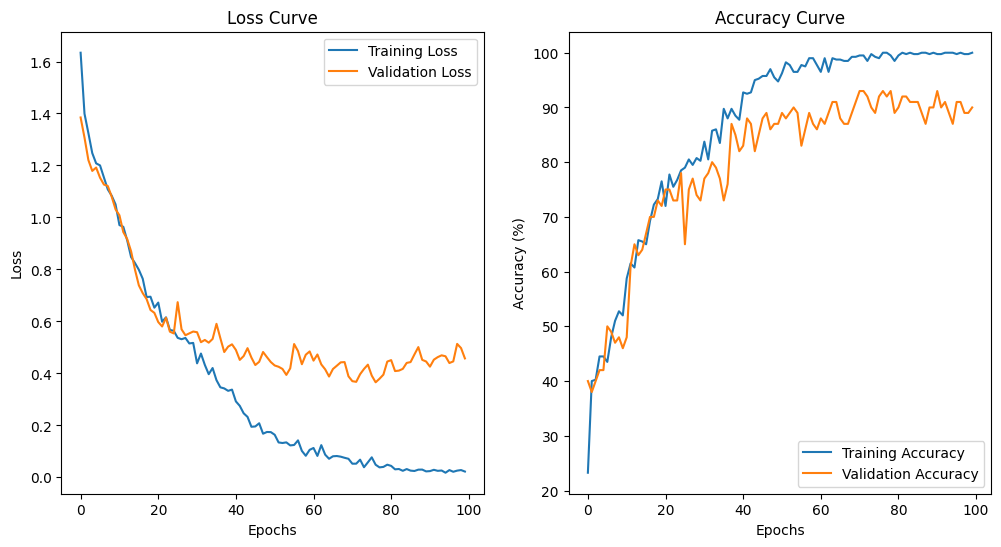

In [55]:
## Display train / valid curves

# Plot loss curves
plt.figure(figsize=(12, 6))

# Plotting Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()


---
## Test the Trained Network

In [56]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
num_classes = 5
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

model.eval()  # prep model for evaluation

with torch.no_grad():
    for data, target in valid_loader:
        data = data.to(device)
        target = target.to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss 
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        
        # compare predictions to true label and update class-wise accuracy
        correct = pred == target
        for i in range(len(target)):
            label = target[i].item()
            class_correct[label] += correct[i].item()
            class_total[label] += 1

#calcul du critère MCC (Matthew's Correlation Coefficient)
if num_classes==2:
    TP=class_correct[0]
    TN=class_correct[1]
    FP=class_total[0]-TP
    FN=class_total[1]-TN
    MCC=(TP*TN-FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    print("Valid MCC: {:.4f}\n".format(MCC))

# calculate and print accuracy of validation set
for i in range(num_classes):
    if class_total[i] > 0:
        print('Valid Accuracy of Label %d: %2d%% (%2d/%2d)' % (
            i, 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Valid Accuracy of Dataset %d: N/A (no testing examples)' % (i+1))

print('\nValid Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

# calculate and print avg test loss
# test_loss = test_loss/len(test_loader.dataset)
# print('Test Loss: {:.6f}\n'.format(test_loss))

# for i in range(num_classes):
#     if class_total[i] > 0:
#         print('Test Accuracy of Label %d: %2d%% (%2d/%2d)' % (
#             i, 100 * class_correct[i] / class_total[i],
#             np.sum(class_correct[i]), np.sum(class_total[i])))
#     else:
#         print('Test Accuracy of Dataset %d: N/A (no testing examples)' % (i+1))

# print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
#     100. * np.sum(class_correct) / np.sum(class_total),
#     np.sum(class_correct), np.sum(class_total)))

Valid Accuracy of Label 0: 100% (20/20)
Valid Accuracy of Label 1: 85% (17/20)
Valid Accuracy of Label 2: 90% (18/20)
Valid Accuracy of Label 3: 85% (17/20)
Valid Accuracy of Label 4: 90% (18/20)

Valid Accuracy (Overall): 90% (90/100)
